In [2]:
import tensorflow as tf 
from tensorflow import keras 
import numpy as np 
import matplotlib.pyplot as plt 
import os 

DIRECTORY_PATH = "PetImages"


## Remove corrupted images 

In [ ]:
n_removed = 0 

for folder in ["Cat", "Dog"]: 
    folder_path = os.path.join(DIRECTORY_PATH, folder)
    for file in os.listdir(folder_path): 
        file_path = os.path.join(folder_path, file)
        #checking 
        try: 
            file_obj = open(file_path, "rb")
            is_jfif = str.encode("JFIF") in file_obj.peek(10)
        finally: 
            file_obj.close()
        if not is_jfif: 
            #remove the file
            os.remove(file_path)
            n_removed += 1

print(f"We removed : {n_removed} files")

## Building datasets

In [3]:

batch_size = 32
image_size = (180,180)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DIRECTORY_PATH, 
    class_names=["Cat", "Dog"], 
    batch_size=batch_size,
    image_size=image_size, 
    validation_split=0.2, 
    seed=1337, 
    subset="training"
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DIRECTORY_PATH, 
    class_names=["Cat", "Dog"], 
    batch_size=batch_size,
    image_size=image_size, 
    validation_split=0.2, 
    seed=1337, 
    subset="validation"
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


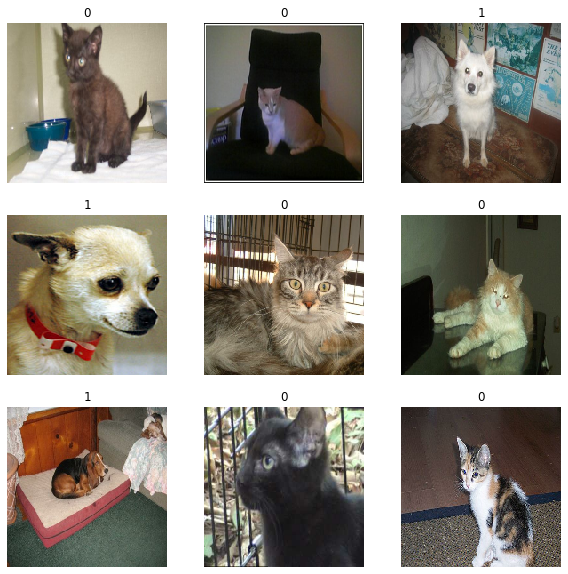

In [4]:
plt.figure(figsize=(10, 10))
#train_ds.take(1) => return the first batch.
#Here the batch size is 32 so it takes 32 images
for images, labels in train_ds.take(1):
    #iterate over the first 9 images
    for i in range(9):
        #setup suplots
        ax = plt.subplot(3, 3, i + 1)
        #convert tensors to numpy arrays with type uint8
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Data Augmentation

In [5]:
#Create a data augmentation pipeline 
data_augmentation = keras.Sequential([
    #first step : flip
    keras.layers.experimental.preprocessing.RandomFlip(
        mode="horizontal"
    ), 
    #second step : rotation
    keras.layers.experimental.preprocessing.RandomRotation(
        factor=0.2
    )
])

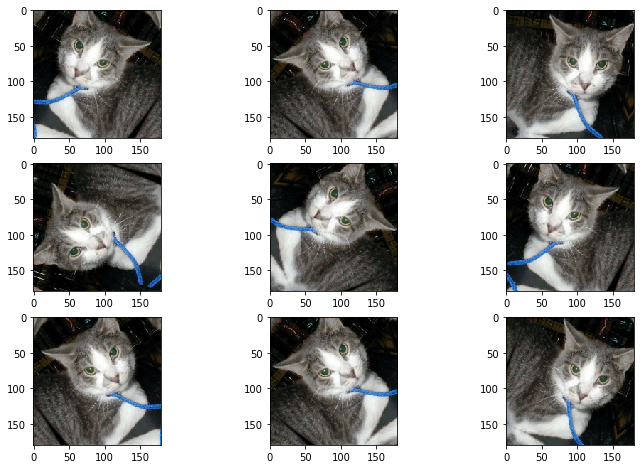

In [6]:
# let's use the pipeline 
plt.figure(figsize=(12,8))
for images, labels in train_ds.take(1): 
    for i in range(9): 
        #affect the pipeline on the whole batch (32 images)
        augm_image = data_augmentation(images)
        ax = plt.subplot(3,3,i + 1) 
        #show first image of the augmented data
        plt.imshow(augm_image[1].numpy().astype("uint8"))


In [7]:
#Good practice => Reduces latency, always write at the end of dataset pipeline
train_df = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)

# The Model : Xception

In [8]:
def make_model(num_classes, image_shape): 
    #Building the head of the model input + preprocessing
    inputs = keras.Input(shape=image_shape)
    #Using the data augmentation pipeline 
    x = data_augmentation(inputs)
    #rescaling
    x = keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    
    #entry block 
    x = keras.layers.Conv2D(32, 3, 2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = keras.layers.Conv2D(64, 3, 1, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    
    previous_block_activation = x
    
    for size in [128, 256, 728]: 
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.activations.relu(x)
        
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.activations.relu(x)
        #max pooling
        x = keras.layers.MaxPooling2D(3, 2, padding="same")(x)
        
        #conv on residual 
        residual = keras.layers.Conv2D(size, 1, 2, padding="same")(previous_block_activation)
        
        #addition 
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    #19x19x728 feature maps 
    
    #middle flow 
    for _ in range(8): 
        x = keras.activations.relu(x)
        #size is still 728
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    #exit : adapted for computation purposes
    

    x = keras.activations.relu(x)
    x = keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x) 
    x = keras.layers.MaxPooling2D(3, 2, padding="same")(x)
    print(x.shape)
    residual = keras.layers.Conv2D(1024, 1, 2, padding="same")(previous_block_activation)
    print(residual.shape)
    x = keras.layers.Add()([x, residual])
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2: 
        activation = "sigmoid"
        unit = 1
    elif num_classes >= 2: 
        activation = "softmax"
        unit = num_classes
    #dropout : last activation
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(unit, activation=activation)(x)
    
    return keras.Model(inputs=inputs, outputs=outputs)


model = make_model(2, image_shape=(*image_size, 3))


(None, 6, 6, 1024)
(None, 6, 6, 1024)


In [9]:
import pydot
import graphviz 

print(pydot.__version__)

1.4.2


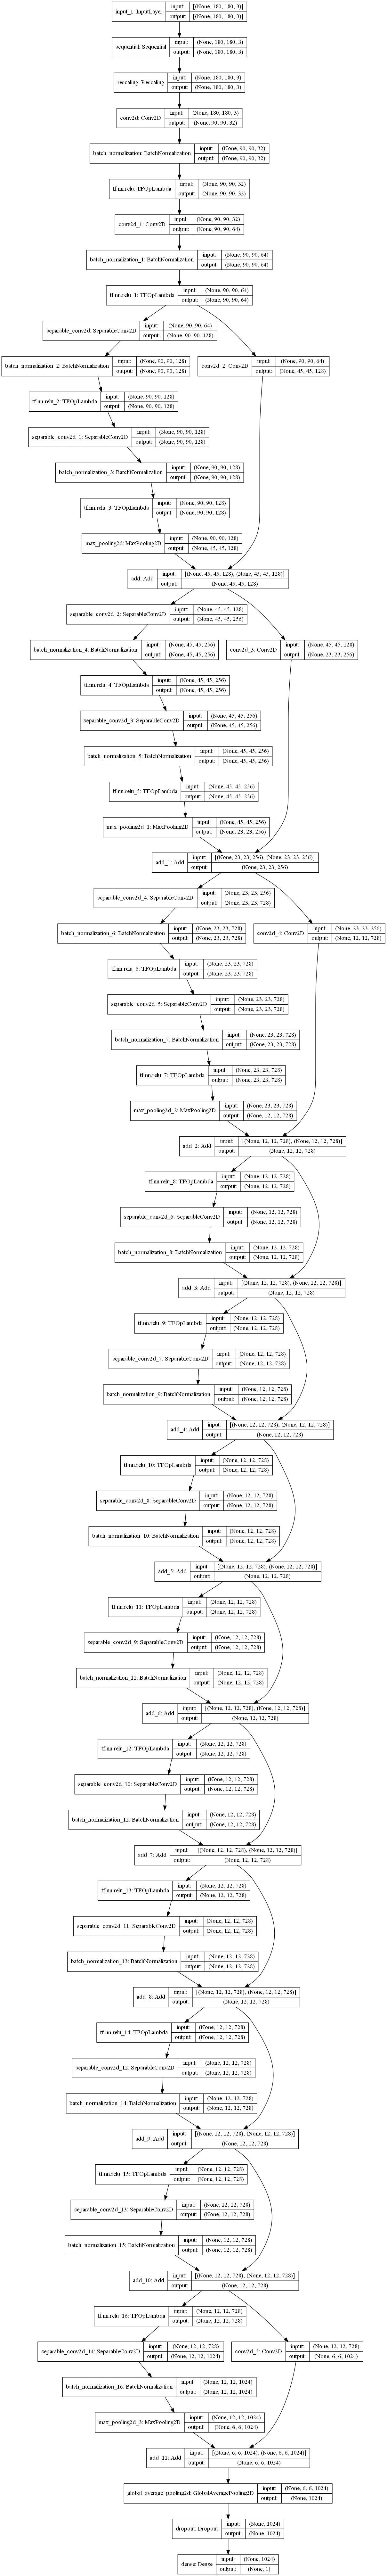

In [10]:
keras.utils.plot_model(model, show_shapes=True)

## Training the model 

In [ ]:
epochs = 50 

#model checkpoint ! 
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    keras.callbacks.TensorBoard(log_dir="logs")
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    #loss
    loss="binary_crossentropy",
    metrics=["accuracy", "Precision", "Recall"],
)

#equivalent of fit in sk
model.fit(
    x=train_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks
)


Epoch 1/50
 11/586 [..............................] - ETA: 2:18:16 - loss: 7.6221 - accuracy: 0.4643 - precision: 0.4027 - recall: 0.4511